##### Copyright 2019 The TensorFlow Authors.

In [6]:
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, #skipping fully connected layer layer, getting straight to the convolutions
                                weights = None) #telling keras that we don't want to use the built-in weights, but the weights that we have downloaded in the local_weights file path
                                                #this means that we don't have to train the model again because the weights are biases are already optimal
                                                #when we save a model, we are just saving the weights and biases of each nuero
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-08-25 23:59:23--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c07::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   169MB/s    in 0.5s    

2020-08-25 23:59:23 (169 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [8]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [9]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2020-08-25 23:59:46--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.197.128, 74.125.28.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   187MB/s    in 0.4s    

2020-08-25 23:59:46 (187 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 18s - loss: 0.3611 - accuracy: 0.8630 - val_loss: 0.1346 - val_accuracy: 0.9520
Epoch 2/20
100/100 - 17s - loss: 0.2301 - accuracy: 0.9125 - val_loss: 0.1309 - val_accuracy: 0.9470
Epoch 3/20
100/100 - 17s - loss: 0.1968 - accuracy: 0.9205 - val_loss: 0.0902 - val_accuracy: 0.9700
Epoch 4/20
100/100 - 17s - loss: 0.1816 - accuracy: 0.9375 - val_loss: 0.1117 - val_accuracy: 0.9640
Epoch 5/20
100/100 - 17s - loss: 0.1715 - accuracy: 0.9390 - val_loss: 0.1105 - val_accuracy: 0.9660
Epoch 6/20
100/100 - 17s - loss: 0.1927 - accuracy: 0.9330 - val_loss: 0.1139 - val_accuracy: 0.9660
Epoch 7/20
100/100 - 17s - loss: 0.1645 - accuracy: 0.9430 - val_loss: 0.1206 - val_accuracy: 0.9660
Epoch 8/20
100/100 - 17s - loss: 0.1577 - accuracy: 0.9455 - val_loss: 0.1468 - val_accuracy: 0.9620
Epoch 9/20
100/100 - 17s - loss: 0.1892 - accuracy: 0.9380 - val_loss: 0.1953 - val_accuracy: 0.9410
Epoch 10/20
100/100 - 17s - loss: 0.1383 - accuracy: 0.9470 - val_loss: 0.1145 - val_accura

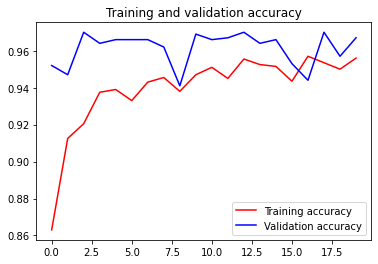

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

[[1.]]
dog


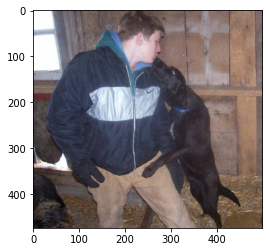

In [19]:
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from PIL import Image
import numpy as np

predictions = model.predict(validation_generator)
url = "/tmp/cats_and_dogs_filtered/validation/dogs/dog.2003.jpg"

img = image.load_img(url, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = np.vstack([x])
result = model.predict(img)
print(result)

show_img = mpimg.imread(url)
plt.imshow(show_img)

if (result > 0):
    print("dog")
else:
    print("cat")